In [0]:
# Importing neccessary packages
import numpy as np
import tensorflow as tf
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=30
)

In [0]:
TARGET_DIM = 224
BATCH_SIZE = 32

In [0]:
train_generator = datagen.flow_from_directory(
    directory='./training/', 
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE,
)

validation_generator = datagen.flow_from_directory(
    directory='./validation/',
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [0]:
train_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [0]:
validation_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [0]:
# Lets try the Xception architecture

base_model = tf.keras.applications.xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

83689472/83683744 [==============================] - 0s 0us/step


In [0]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
print('Layers in Xception: ' + str(len(base_model.layers)))

Layers in Xception: 132


In [0]:
preds = base_model.output
preds = tf.keras.layers.Flatten()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.5)(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.4)(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
model.layers[-15].name

'block14_sepconv1'

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005, momentum=0.09),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Create directory in drive for storing model
!mkdir drive/My\ Drive/food_11_weights

In [0]:
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/xception-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Unfreeze last 15 layers and train them only

for layers in model.layers[:-15]:
    layers.trainable = False

for layers in model.layers[-15:]:
    layers.trainable = True

In [0]:
#Let's train the model 50 epochs

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint],
    epochs=50
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 2.4828 - acc: 0.1358
Epoch 00001: val_acc improved from -inf to 0.13113, saving model to ./drive/My Drive/food_11_weights/xception-01-0.13.hdf5
308/308 [==============================] - 239s 777ms/step - loss: 2.4828 - acc: 0.1358 - val_loss: 63.3142 - val_acc: 0.1311
Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 2.3135 - acc: 0.1506
Epoch 00002: val_acc improved from 0.13113 to 0.16005, saving model to ./drive/My Drive/food_11_weights/xception-02-0.16.hdf5
308/308 [==============================] - 240s 778ms/step - loss: 2.3135 - acc: 0.1506 - val_loss: 2.3510 - val_acc: 0.1600
Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 2.2945 - acc: 0.1627
Epoch 00003: val_acc improved from 0.16005 to 0.16647, saving model to ./drive/My Drive/food_11_weights/xception-03-0.17.hdf5
308/308 [================

In [0]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
history = model.history.history

Text(0, 0.5, 'Accuracy')

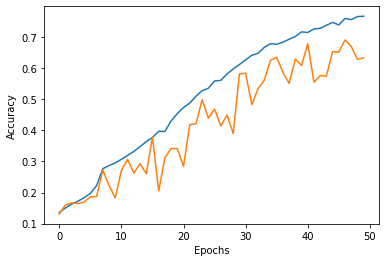

In [0]:
plt.plot(range(50), history['acc'])
plt.plot(range(50), history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Observations:

The validation accuracy is far from training accuracy so model is starting to overfit on training data.

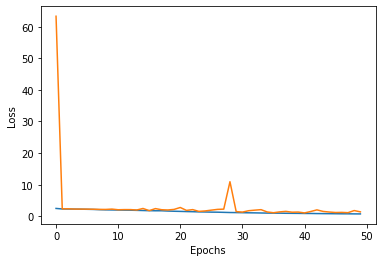

In [0]:
plt.plot(range(50), history['loss'])
plt.plot(range(50), history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Training results:

No of epochs: 50<br>
Learning rate: 0.005<br>
Momentum: 0.09<br>
Optimizer: RMSprop<br>

### Best model results 
Training accuracy: 0.7156<br>
Validation accuracy: 0.67932<br>
Found at epoch: 41<br>

In [0]:
#Let's train the model 30 epochs

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint],
    epochs=30
)

Epoch 1/30
308/308 [==============================] - ETA: 0s - loss: 0.7340 - acc: 0.7743
Epoch 00001: val_acc did not improve from 0.69159
308/308 [==============================] - 411s 1s/step - loss: 0.7340 - acc: 0.7743 - val_loss: 1.5450 - val_acc: 0.6174
Epoch 2/30
308/308 [==============================] - ETA: 0s - loss: 0.7338 - acc: 0.7712
Epoch 00002: val_acc did not improve from 0.69159
308/308 [==============================] - 279s 905ms/step - loss: 0.7338 - acc: 0.7712 - val_loss: 1.3423 - val_acc: 0.6057
Epoch 3/30
308/308 [==============================] - ETA: 0s - loss: 0.7023 - acc: 0.7810
Epoch 00003: val_acc improved from 0.69159 to 0.69626, saving model to ./drive/My Drive/food_11_weights/xception-03-0.70.hdf5
308/308 [==============================] - 352s 1s/step - loss: 0.7023 - acc: 0.7810 - val_loss: 1.1461 - val_acc: 0.6963
Epoch 4/30
308/308 [==============================] - ETA: 0s - loss: 0.6939 - acc: 0.7838
Epoch 00004: val_acc improved from 0.6962